# ```3D Reconstruction Using the NeRF Model:```

**Assignment Plan:** we will implement a simple model for 3D scene reconstruction. To do this, we will write the model architecture as well as the frame rendering algorithm.

**Assignment Goal:** to get familiar with the basic principles of how modern multi-view reconstruction models work.

**Format:** complete the ```TODO``` sections.

## Import Libraries

In [124]:
import os
import gc
import json
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.jit as jit
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

assert device == 'cuda', "For this hometask we need a GPU!"

## Data preparation

Let's download and unzip the data. As a trained sample we will take a synthetic dataset with a Lego tractor model.

In [126]:
import os
import zipfile
import wget


if not os.path.exists('nerf_synthetic'):
    wget.download('http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip', 'nerf_example_data.zip')
    with zipfile.ZipFile('nerf_example_data.zip', 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('nerf_example_data.zip')

# if not os.path.exists('nerf_synthetic'):
#     !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
#     !unzip nerf_example_data.zip
#     clear_output()

Along with the pictures, the data contains camera parameters, which we consider below.

In [127]:
def read_json(file_dir):
    with open(file_dir) as fp:
        data = json.load(fp)
    return data

def read_focal(image_width, metadata) -> float:
    camera_angle_x = float(metadata["camera_angle_x"])
    return 0.5 * image_width / np.tan(0.5 * camera_angle_x)

def read_data(base_dir, metadata, scale=1, count=None):
    imgs, poses = [], []

    if count is None:
        count = len(metadata["frames"])

    for frame in tqdm(metadata["frames"][:count], desc=f"Loading Data"):
        img = os.path.join(base_dir, f"{frame['file_path'][2:]}.png")
        img = Image.open(img)

        if scale < 1.:
            w, h = img.width, img.height
            w = int(np.floor(scale * w))
            h = int(np.floor(scale * h))
            img = img.resize((w, h), Image.LANCZOS)

        img = transforms.ToTensor()(img).permute(1, 2, 0)
        img = img[:, :, :3] * img[:, :, -1:]
        imgs.append(img)

        pose = frame["transform_matrix"]
        pose = torch.FloatTensor(pose)
        poses.append(pose)

    imgs = torch.stack(imgs, dim=0)
    poses = torch.stack(poses, dim=0)

    return imgs, poses

In [128]:
metadata_train = read_json("./nerf_synthetic/lego/transforms_train.json")
metadata_val = read_json("./nerf_synthetic/lego/transforms_val.json")
metadata_test = read_json("./nerf_synthetic/lego/transforms_test.json")

len(metadata_train["frames"]), len(metadata_val["frames"]), len(metadata_test["frames"])

(100, 100, 200)

### Training Data (15 points)

In the NeRF model, to obtain the final color, we cast rays from the camera coordinates towards the object through each pixel of the image. At each point along the ray $r(t) = o + t \cdot d$, the model will predict the color and density of the object, which will then be aggregated into the overall color.


In [129]:
def get_ray_direction(H, W, focal):
    """
    Get ray directions for all pixels in camera coordinate.
    Inputs:
        H, W, focal: image height, width and focal length
    Outputs:
        ray directions: (H, W, 3), the direction of the rays in camera coordinate
    """
    i, j = torch.meshgrid(torch.linspace(0, W - 1, W),
                          torch.linspace(0, H - 1, H),
                          indexing='ij')
    i, j = i.t(), j.t()
    return torch.stack(
        [
            (i - 0.5 * W) / focal,
            - (j - .5 * H) / focal,
            - torch.ones_like(i)
        ], -1)

@jit.script
def get_rays_with_dir(directions, c2w):
    """
    Get ray origin and normalized directions in world coordinate for all pixels in one image.
    Inputs:
        directions: (H, W, 3) precomputed ray directions in camera coordinate
        c2w: (4, 4) transformation matrix from camera coordinate to world coordinate
    Outputs:
        rays_o: (H, W, 3), the origin of the rays in world coordinate
        rays_d: (H, W, 3), the normalized direction of the rays in world coordinate
    """
    # Rotate ray directions from camera coordinate to the world coordinate
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)      # (H, W, 3)
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)

    # The origin of all rays is the camera origin in world coordinate
    rays_o = c2w[:3, 3].expand(rays_d.shape)                                # (H, W, 3)
    return rays_o, rays_d

def build_rays(H, W, focal, poses):
    """
    Generate dataset rays (origin and direction)
    Inputs:
        dataset (BlenderDataset): dataset context
        H (int): frame height
        W (int): frame width
        focal (float): camera focal length
        poses (Tensor): camera to world matrices (N, 4, 4)
    Outputs:
        ros (Tensor): ray origins (N, H, W, 3)
        rds (Tensor): ray directions (N, H, W, 3)
    """
    N = poses.size(0)

    prd = get_ray_direction(H, W, focal).to(poses.device)
    ros = torch.zeros((N, H, W, 3), dtype=torch.float32)
    rds = torch.zeros((N, H, W, 3), dtype=torch.float32)

    c2ws = tqdm(poses, desc=f"Building Rays")
    for i, c2w in enumerate(c2ws):
        ros[i], rds[i] =  get_rays_with_dir(prd, c2w)

    return ros, rds

In [130]:
class NeRFDataset(Dataset):
    def __init__(self, metadata, scale=1, data_path="./nerf_synthetic/lego/", device='cpu', train=False):

        self.metadata = metadata

        self.images, self.poses = read_data(data_path, self.metadata , scale=scale)
        self.images = self.images.to(device)
        self.poses = self.poses.to(device)

        H, W = self.images.shape[1:3]
        self.focal = read_focal(W, self.metadata)

        ro, rd = build_rays(H, W, self.focal, self.poses)

        if train:
            self.ro = ro.view(-1, 3)
            self.rd = rd.view(-1, 3)
            self.images = self.images.view(-1, 3)
        else:
            self.ro = ro
            self.rd = rd

        assert self.images.size() == self.ro.size()
        assert self.images.size() == self.rd.size()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            'image': self.images[idx],
            'ro': self.ro[idx],
            'rd': self.rd[idx]
        }

In [131]:
dataset_train = NeRFDataset(metadata_train, scale=0.125, train=True)
dataset_val = NeRFDataset(metadata_val, scale=0.125)

Loading Data:   0%|          | 0/100 [00:00<?, ?it/s]

Building Rays:   0%|          | 0/100 [00:00<?, ?it/s]

Loading Data:   0%|          | 0/100 [00:00<?, ?it/s]

Building Rays:   0%|          | 0/100 [00:00<?, ?it/s]

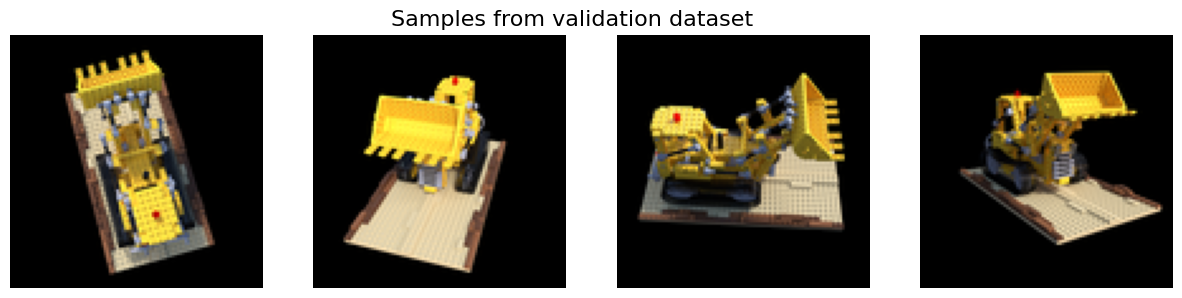

In [132]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(dataset_val.images[i])
    axs[i].axis('off')
fig.suptitle("Samples from validation dataset", y=0.8, fontsize=16)
plt.show()

## Model Architecture (40 points)

[NeRF](https://www.matthewtancik.com/nerf) represents a scene using a fully connected neural network.

The input consists of a point in space $x$ and a ray direction $d$.
The model returns density $\sigma$ and color $C$.
The density $\sigma$ depends on the input point coordinates, while the color depends on both the coordinates and the ray direction. For this, the architecture is divided into several blocks:
$$
\begin{align}
h_1(x) &= \text{block}_1(x) \\
h_2(x), \sigma(x) &= \text{block}_2(x, h_1) \\
c(x, d) &= \text{block}_3(h_2, d)
\end{align},
$$
where each block represents a fully connected neural network.
Each block could take coordinates as explicit input, however, an approach using positional encoding of network inputs proves to be more successful.
Let's describe it in more detail.

Intuitively, a 3D scene model should allow for sharp changes in color and density depending on $x$. However, [it turns out](https://arxiv.org/abs/2006.10739) that a fully connected network requires long training to achieve this effect. As a workaround, the NeRF model proposed using positional encoding of the input:
$$
\gamma_L(x) = [x, \cos(2^0 \pi x), \sin(2^0 \pi x), \dots, \cos(2^{L - 1} \pi x), \sin(2^{L - 1} \pi x)].
$$
The formula above is given for scalar $x$, and for vector input $x$, the encoding is applied to each coordinate separately.

In the end, the architecture has the following form:
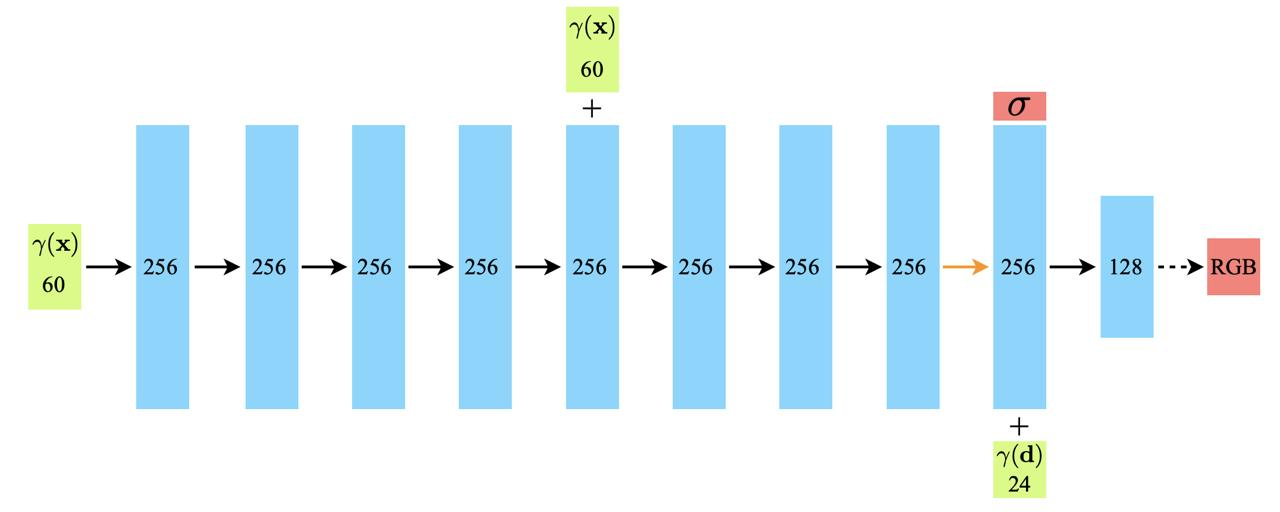

Instead of a single large MLP that directly processes positional encoded coordinates, Voxel NeRF utilizes a discrete 3D voxel grid. This grid stores learnable feature vectors at each voxel center. When we want to determine the properties (density and color) of a point in space, we first find its corresponding feature vector by interpolating from the features of its neighboring voxels. These interpolated features are then fed into smaller MLPs to predict density and color.

This approach has two main components:

1.  **VoxelGrid**:
    *   This module defines a 3D grid (e.g., 128x128x128) within a specified bounding box (e.g., [bbox_min, bbox_max] on each axis).
    *   Each cell (voxel) in this grid stores a learnable feature vector of a predefined dimension (feature_dim). These features are initialized (e.g., randomly) and optimized during training.
    *   When queried with a batch of 3D points xyz (these are the sample points along rays), the VoxelGrid first normalizes these coordinates to fit within the canonical grid range (typically [-1, 1]).
    *   It then uses trilinear interpolation to sample features from the grid at these normalized coordinates. This means that for any given point, its feature representation is a weighted average of the features stored at the 8 corners of the voxel cell it falls into.

2.  **VoxelNeRF**:
    *   We define two small Multi-Layer Perceptrons (MLPs):
        *   **Density MLP (density_mlp)**: Takes the interpolated feature vector (obtained from VoxelGrid for a given point) as input and outputs a single scalar value representing the volume density $\sigma$ at that point.
        *   **Color MLP (color_mlp)**: Also takes the interpolated feature vector as input and outputs a 3-vector representing the RGB color C at that point.
    *   **Note on View Dependence**: We don't use the viewing direction (directions) as input to the color_mlp. This means the predicted color will only be dependent on the spatial location (via its interpolated features), not the viewing angle.

The key idea is that the VoxelGrid learns to store a compressed representation of the scene's geometry and appearance, and the small MLPs learn to decode these features into density and color.




In [182]:
class VoxelGrid(nn.Module):
    def __init__(self, grid_size=128, feature_dim=32, bbox_min=-1.0, bbox_max=1.0):
        super(VoxelGrid, self).__init__()
        self.grid_size = grid_size
        self.feature_dim = feature_dim
        self.bbox_min = bbox_min
        self.bbox_max = bbox_max

        self.voxel_features = nn.Parameter(torch.rand(feature_dim, grid_size, grid_size, grid_size))

    def normalize_coords(self, xyz):
        '''
        Normalize coordinates from world space to [-1, 1] based on bbox_min and bbox_max
        '''
        return (xyz - self.bbox_min) / (self.bbox_max - self.bbox_min) * 2 - 1.0

    def forward(self, xyz):
        batch_size = xyz.shape[0]

        normalized_xyz = self.normalize_coords(xyz)

        # Reshape for grid_sample function (needs 5D input: [N, C, D, H, W])
        # (we use batch size of 1 and treat our batch as spatial dimension)
        grid = normalized_xyz.view(1, batch_size, 1, 1, 3)

        # Permute voxel features to [1, feature_dim, grid_size, grid_size, grid_size]
        voxel_features = self.voxel_features.unsqueeze(0)

        sampled_features = F.grid_sample(
            voxel_features,
            grid,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )

        # Reshape back to [batch_size, feature_dim]
        sampled_features = sampled_features.squeeze().transpose(0, 1)

        return sampled_features


class VoxelNeRF(nn.Module):
    def __init__(self, grid_size=128, feature_dim=32, hidden_dim=128, bbox_min=-1.0, bbox_max=1.0):
        super(VoxelNeRF, self).__init__()

        self.voxel_grid = VoxelGrid(grid_size, feature_dim, bbox_min, bbox_max)

        # We don't need very deep mlp's for density_mlp and color_mlp: 1-2 linear layers are enough

        self.density_mlp = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )

        self.color_mlp = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3),
            nn.Sigmoid()
        )

    def forward(self, origins, directions):
        '''
        origins, directions: [batch_size, 3]
        '''

        voxel_features =  self.voxel_grid(origins)
        # В задании написано, что directions использовать не нужно, это отельно отмечено в "Note on View Dependence"
        # Но для улучшения модели можно было бы соединить voxel_features и directions для color_mlp
        sigma = self.density_mlp(voxel_features)
        c = self.color_mlp(voxel_features)

        return c, sigma.squeeze()

In [184]:
temp_model = VoxelNeRF().cpu()

temp_origins = torch.rand(10, 3)
temp_directions = torch.rand(10, 3)

c, sigma = temp_model(temp_origins, temp_directions)

assert c.shape == (10, 3), f"Output 'c' should have shape (10, 3), but got {c.shape}"
assert sigma.shape == (10,), f"Output 'sigma' should have shape (10,), but got {sigma.shape}"

### Render rays (35 points)

After computing density and color along the ray, we calculate the pixel color in the image by aggregating color and density using the $\alpha$-compositing algorithm.

For $N$ points $\{x_i\}_{i=1^N}$ of ray $r$, let's introduce the notation $\sigma_i = \sigma(x_i)$ and $c_i = c(x_i, d)$, where $d$ denotes the ray direction.
The final color $C(r)$ can be calculated using formula (3) from the original [paper](https://arxiv.org/abs/2003.08934):
$$
C(r) = \sum_{i=1}^N \alpha_i \left( \prod_{j < i} (1 - \alpha_j) \right) c_i
$$
for opacity $\alpha_i = 1 - \exp(-\sigma_i \delta_i)$ and ray partition width $\delta_i$ (we can assume $\delta_i = \tfrac{1}{N}$).

The formula reweights the values $c_i$, giving priority to opaque points encountered at earlier indices $i$.
The physical interpretation of the algorithm is described in [this](https://courses.cs.duke.edu/spring03/cps296.8/papers/max95opticalModelsForDirectVolumeRendering.pdf) paper.
The weight $w_i = \alpha_i \prod_{j < i} (1 - \alpha_i)$ corresponds to the probability of an event where a light particle emitted with probability $\alpha_i$ from point $i$ will pass through points $j < i$ with transmission probability $(1 - \alpha_j)$ and reach the camera.
The color $C(r)$, in turn, corresponds to the average color of the arriving particles.

Below you need to implement the pixel color calculation using the algorithm described above.

In [183]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((
        torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
        accumulated_transmittance[:, :-1]),
        dim=-1
    )

def get_ray_samples(ray_origins, hn, hf, nb_bins, device):
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)

    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)

    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1)), -1)
    return t, delta

def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):

    device = ray_origins.device

    t, delta = get_ray_samples(ray_origins, hn, hf, nb_bins, device)

    # TODO: Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(-1) * ray_directions.unsqueeze(1)
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)

    colors, sigma = nerf_model(x.view(-1, 3), ray_directions.reshape(-1, 3))

    # TODO: calculate the color of pixel C based on the variables obtained above

    alpha = 1.0 - torch.exp(-sigma.view(-1, nb_bins) * delta)
    weights = alpha * compute_accumulated_transmittance(1.0 - alpha)
    c = torch.sum(weights.unsqueeze(-1) * colors.view(-1, nb_bins, 3), dim=1)

    return c

## Training (10 points)

Let's train the model using the components implemented above.

In [185]:
def psnr(img1, img2):
    return -10.0 * torch.log10(F.mse_loss(img1, img2))

In [186]:
def train(model, optimizer, scheduler, train_loader, val_img, device='cuda', hn=0, hf=1, nb_epochs=10, nb_bins=192, chunk_size=1024*6):

    psnr_values_val = []
    psnr_values_train = []

    for epoch in tqdm(range(nb_epochs), desc="Epochs"):
        psnr_train_epoch = []

        for batch in tqdm(train_loader, total=len(train_loader), leave=False, desc="Train batch"):
            model.train()
            ro = batch['ro'].to(device)
            rd = batch['rd'].to(device)
            color_gd = batch['image'].to(device)

            color_gen = render_rays(model, ro, rd, hn=hn, hf=hf, nb_bins=nb_bins)
            loss = F.mse_loss(color_gen, color_gd)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            psnr_train_epoch.append(psnr(color_gd, color_gen).item())


        psnr_values_train.append(np.mean(psnr_train_epoch))

        scheduler.step()

        with torch.no_grad():
            model.eval()
            ray_origins_val = val_img['ro'].view(-1, 3)
            ray_directions_val = val_img['rd'].view(-1, 3)
            image_gd_val = val_img['image'].view(-1, 3)
            rendered_chunks_val = []

            for i in tqdm(range(0, ray_origins_val.shape[0], chunk_size), leave=False, desc="Validation"):
                ro_chunk_val = ray_origins_val[i:i+chunk_size].to(device)
                rd_chunk_val = ray_directions_val[i:i+chunk_size].to(device)

                rgb_map_chunk_val = render_rays(model, ro_chunk_val, rd_chunk_val, hn=hn, hf=hf, nb_bins=nb_bins)
                rendered_chunks_val.append(rgb_map_chunk_val.cpu().detach())

            image_gen_val = torch.cat(rendered_chunks_val, dim=0)
            val_psnr = psnr(image_gd_val.cpu().detach(), image_gen_val)
            psnr_values_val.append(val_psnr)

            # clear_output(wait=True)
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(range(len(psnr_values_train)), psnr_values_train)
            plt.title(f"Train PSNR")

            plt.subplot(2, 2, 2)
            plt.plot(range(len(psnr_values_val)), psnr_values_val)
            plt.title("Val PSNR")

            plt.subplot(2, 2, 3)
            plt.imshow(image_gd_val.view(*val_img['image'].shape).cpu().detach().numpy())
            plt.axis("off")
            plt.title("Ground Truth Image (Val)")

            plt.subplot(2, 2, 4)
            plt.imshow(image_gen_val.view(*val_img['image'].shape).cpu().detach().numpy())
            plt.axis("off")
            plt.title("Generated Image (Val)")

            plt.suptitle(f"Results of epoch {epoch+1}")
            plt.show()

    return psnr_values_train, psnr_values_val

In [ ]:
# You can change any hyperparameters!
model = VoxelNeRF(
    grid_size=128,
    feature_dim=48,
    hidden_dim=32,
    bbox_min=torch.tensor([-3, -3, -3], device=device),
    bbox_max=torch.tensor([3, 3, 3], device=device),
).to(device)

model_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[3, 4, 9], gamma=0.5)

g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(dataset_train, batch_size=4000, shuffle=True, generator=g)
val_img = dataset_val[5]

psnr_train, psnr_val = train(model, model_optimizer, scheduler, train_loader, val_img, nb_epochs=10, device=device, hn=2, hf=6)

assert max(psnr_val) > 24, "Ты НЕ выполнил/a задание на 5+. PSNR как бы невзначай НЕ сбивается в сторону :("

Кстати, я заметил, что разные начальные инициализации `voxel_features` дают разные результаты. В случае с `randn` у меня даже не получилось пройти порог качества. Но в целом было интересно понаблюдать за прогрессом на сгенерированном изображении для `randn` с разными дисперсиями, для `rand` с разными средними и разным масштабированием, для разных констант от `0` до `1`.